# 0 - Information

# 1 - Packages

In [1]:
# Mathematical Packages
import numpy as np
from math import *
from scipy.integrate import quad, odeint

# Graphic packages
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

# Time package
import time

# Progress bar
import tqdm as tqdm

# 2 - Simulations

## 2.0 - Sampling of Gaussians

In [2]:
def G(d, N):
    """Generation of d * N samples of independant gaussians."""
    
    # Generation of d * N independant gaussians of dimension d
    G = np.random.normal(0, 1, N * d)
    G = G.reshape((1, -1))
    
    return G

In [3]:
def Gn(n, d, N):
    """Generation of (n, d * N) independant samples of gaussians."""
    
    # Saving array for the samples
    Gn_T = np.zeros((n, d*N))

    for i in range(n):
        Gn_T[i, :] = G(d, N)
        
    return Gn_T

## 2.1 - Simulation of correlated brownian movement

In [4]:
def W_T(G_N, N, rho, T):
    """Sample a brownian according at the last Time step."""
    
    # Correlation matrix
    C = np.array([[int(i==j) + rho * int(i!=j) for i in range(d)] for j in range(d)])
    
    # Extract the lower traingular matrix according to the cjolesky decomposition
    L = np.linalg.cholesky(C)

    # Computaion of W_{T}
    rep_L = np.tile(L, (1, N))
    W = (sqrt(T / N) * rep_L.dot(G_N)).reshape(-1)

    return W

In [5]:
def Wn(Gn_T, n, d, rho, T, theta=0):
    """Return n samples of a brownian motion for the given parameters"""
    
    # Saving array for the samples
    Wn_T = np.zeros((n, d))

    for i in range(n):
        G_N_theta = Gn_T[i, :].reshape((-1, 1)) + theta
        Wn_T[i, :] = W_T(G_N_theta, N, rho, T)

    return Wn_T

## 2.2 - Payoff Function

In [6]:
def BS(S_0, Wn_T, r, sigmas):
    """Return the value of the asset for the given initial price S_0 at time T."""

    # Parameters
    dim, _ = np.shape(sigmas)
    
    S_T = S_0 * np.exp((r - (sigmas.T ** 2) / 2) * T + sigmas.T * Wn_T)
    
    return S_T.reshape((-1, dim))

In [7]:
def f(Gn_T, d, S_0, r, sigmas, portofolio, K, T, theta=0):
    """Return the payoff function for a given value of a brownian movement"""

    # Parameters
    n, _ = np.shape(Gn_T)
    
    # Compute the Wn_T
    Wn_T = Wn(Gn_T, n, d, rho, T, theta=theta)
    
    # Initialisation of f
    f = np.zeros((n, 1))
    
    # Compute the payoff
    S_T = BS(S_0, Wn_T, r, sigmas)
    f = (S_T.dot(portofolio).reshape((-1, 1)))
    
    return np.exp(-r * T) * np.where(f - K < 0, 0, f - K)

## 2.3 - Gradient and Hessian functions

In [8]:
def grad_un_v(A, v, Gn_T, fn):
    """Return the gradient value of u_n."""
    
    # Reshape v
    v = v.reshape((-1, 1))
    
    # Compute the gradient    
    first = (A.T).dot(A).dot(v).reshape((-1, 1))
    fn_2 = fn ** 2
    up_sum = np.sum((A.T).dot(Gn_T.T) * fn_2.T * (np.exp(-(A.dot(v).T).dot(Gn_T.T))), axis=1)
    bottom_sum = np.sum(fn_2.T * (np.exp(-(A.dot(v).T).dot(Gn_T.T))), axis=1)

    # Reshape
    up_sum = up_sum.reshape((-1, 1))
    
    # Sum of all  the previous elements
    grad = first - up_sum / bottom_sum

    return grad

In [9]:
def hessian_un_v(A, v, Gn_T, fn):
    """Return the hessian of u_n."""
    
    # Parameters
    n, d = np.shape(Gn_T)
    
    # Initialisation of the hessian matrix
    hess = A.T.dot(A)
    
    # Computation of f
    fn_2 = (fn ** 2).reshape((-1, 1))
    
    # Reshape v
    v = v.reshape((-1,1))
    
    # f ** 2 * exp()
    temp = fn_2 * np.exp(-Gn_T.dot(A.dot(v)))
    
    # The different sums
    up_sum_1 = 0
    up_sum_2 = 0
    
    for i in range(n):
        Gi = Gn_T[i, :].reshape((-1, 1))
        up_sum_1 += (A.T.dot(Gi).dot(Gi.T).dot(A)) * temp[i, 0]
        up_sum_2 += A.T.dot(Gi) * temp[i, 0]

    bottom_sum = np.sum(temp)

    hess = hess + up_sum_1 / bottom_sum - (up_sum_2).dot(up_sum_2.T) / ((bottom_sum)**2)

    return hess

## 2.4 - Newton Algorithm

In [10]:
def Newton(A, nu_0, Gn_T, fn, eps=10**(-6), max_iter=15):
    """Execute the Newton algorithm."""
    
    # Initialisation of xn_k
    nu_k = nu_0.reshape((-1,1))
    
    # Initialisation of the number of step
    nb_iter = 0
    
    # Initialisation of the gradient
    g = grad_un_v(A, nu_k, Gn_T, fn)
    
    while np.linalg.norm(g) > eps and nb_iter < max_iter:
        
        # Computation of the gradient and the hessian
        g = grad_un_v(A, nu_k, Gn_T, fn)
        h = hessian_un_v(A, nu_k, Gn_T, fn)

        # Execute a step of the Newton Alforithm
        d = - np.linalg.solve(h, g)
        nu_k = nu_k + 1 * d
        
        # Update number of steps
        nb_iter += 1
        
    return nu_k

## 2.5 Monte-Carlo and RRIS

In [11]:
def MC(Gn_T, fn, A, nu_0, r, T, S_0, sigmas, portofolio, K, eps=10e-6):
    """Approximation of the expectation of f(G) through the RRIS algorithm"""

    # Initialisation of Mn
    Mn = np.mean(fn)
    
    return Mn, np.array([-1])

In [12]:
def RRIS(Gn_T, fn, A, nu_0, r, T, S_0, sigmas, portofolio, K, eps=10e-6):
    """Approximation of the expectation of f(G) through the RRIS algorithm"""
    
    # Compute the best parameter \nu
    nu_n = Newton(A, nu_0, Gn_T, fn, eps=eps)

    # Theta
    theta = A.dot(nu_n).reshape((-1, 1))
    
    # Computation of Mn
    power = Gn_T.dot(A.dot(nu_n)) + np.linalg.norm(A.dot(nu_n)) ** 2 / 2
    Mn = f(Gn_T, d, S_0, r, sigmas, portofolio, K, T, theta=theta) * np.exp(-power)
    
    return np.mean(Mn), nu_n

## 2.6 - Simulations

In [13]:
def simulations(Gn_s, fn, n, A, nu_0, r, T, S_0, sigmas, portofolio, K,
                simulator=MC):
    """Executes n simulations on simulator."""
        
    # Computation of the expectation
    E, nu_n = simulator(Gn_s, fn, A, nu_0, r, T, S_0, sigmas, portofolio, K)
        
    return E, nu_n

## 2.7 - Parameters

In [14]:
## Parameters :
d = 40              # actif
r = 0.05            # Facteur d'actualisation
T = 1               # maturite
S_0 = 50            # Initialisation des modèles de BS
sigmas = np.zeros((d, 1)) + 0.2                     # Sigma des modèles de BS
portofolio = np.zeros((d, 1)) + 1 / d               # Répartition entre les différents BS
K = 45                                              # Strike
n = 10000                                           # Nombre de simulations pour Monte-Carlo
N = 1                                               # Nombre de points de discrétisation
rho = 0.1                                           # Correlation (volatility)
nu_0 = np.random.rand(d * N).reshape((d, 1))
A = np.identity(d * N)

## 2.8 - Results

In [15]:
# Sampling of gaussians
Gn_s = Gn(n, d, N)

# Computation of fn
fn = f(Gn_s, d, S_0, r, sigmas, portofolio, K, T)

In [16]:
## Runs the simulation
E, nu_n = simulations(Gn_s, fn, n, A, nu_0, r, T, S_0, sigmas, portofolio, K,
                      simulator=RRIS)

In [17]:
np.mean(E)

7.194512838363098

# 3 - Variances and graphics

## 3.1 - Variance of the estimators

In [18]:
def varMC(Gn_s, fn, A, nu_n):
    """Compute the variance for a classic MC estimator."""
    
    # Paramters
    n, _ = np.shape(fn) 
    
    # Computation of the two terms
    sum_1 = np.mean(fn ** 2)
    sum_2 = np.mean(fn) **2
    
    return sum_1 - sum_2

In [19]:
def varRRIS(Gn_s, fn, A, nu_n):
    """Computation of the variance of the estimator """
    
    def v_n_f(theta, A, fn, Gn_s):
        """Computes v_n."""
        
        argexpo = - Gn_s.dot(theta) + np.linalg.norm(theta) ** 2 / 2
        v_n = np.mean(fn ** 2 * np.exp(argexpo))
        
        return v_n

    # Theta_n^f
    theta = A.dot(nu_n).reshape((-1, 1))
    
    # Compute v_n^f(theta_n^f)
    v_star = v_n_f(theta, A, fn, Gn_s)
    
    # Computation of Mn
    power = Gn_s.dot(theta) + np.linalg.norm(theta) ** 2 / 2
    Mn = f(Gn_s, d, S_0, r, sigmas, portofolio, K, T, theta=theta) * np.exp(-power)
    Mn = np.mean(Mn)
    
    return v_star - Mn ** 2

## 3.2 - Confidence interval

In [20]:
def confidenceBounds(E, Gn_s, fn, A, nu_n, var_func=varMC):
    """Return the bounds of the 95% confidence interval."""
    
    # Parameters
    n, _ = np.shape(Gn_s)    
    
    # Compute the variance
    var = var_func(Gn_s, fn, A, nu_n)
    
    # Compute the bounds
    lower = E - 1.96 * (var / n) ** (1/2)
    upper = E + 1.96 * (var / n) ** (1/2)
    
    return [lower, upper]

## 3.3 - Estimations for different number of samplings 

In [21]:
def estimations(nb, low, high, A, nu_0, r, T, S_0, N, d, sigmas, portofolio, K,
                simulator=MC, var_func=varMC):
    """Compute the estimations of the price for different number of sampling"""
    
    # List of the different number of samplings
    n_s = np.linspace(low, high, nb, dtype=int)
    
    # Saving array of time computing, Expectation and Confidence bounds
    low_l = np.zeros(nb)
    high_l = np.zeros(nb)
    E = np.zeros(nb)
    time_l = np.zeros(nb)
    
    for i in tqdm.tqdm(range(nb)):
        
        # Extract n
        n = n_s[i]
        
        # Initialisation of the CPU time
        time_init = time.clock()
        
        # Sampling of gaussians
        Gn_s = Gn(n, d, N)

        # Computation of fn
        fn = f(Gn_s, d, S_0, r, sigmas, portofolio, K, T)

        # Runs the simulation
        E[i], nu_n = simulations(Gn_s, fn, n, A, nu_0, r, T, S_0, sigmas, portofolio, K,
                                 simulator=simulator)
        
        # Save time
        time_l[i] = time.clock() - time_init
        
        # Compute the bounds of the confidence interval
        low_l[i], high_l[i] = confidenceBounds(E[i], Gn_s, fn, A, nu_n, var_func=var_func)
        
    return E, low_l, high_l, time_l

In [37]:
# Compute estimations for MC
E_MC, low_l_MC, high_l_MC, time_l_MC = estimations(20, 1000, 20000, A, nu_0,
                                                   r, T, S_0, N, d, sigmas, portofolio, K,
                                                   simulator=MC, var_func=varMC)

# Display time_l
print(time_l_MC)

100%|██████████| 20/20 [07:52<00:00, 38.20s/it]

[ 17.161507  35.000211  49.551302 131.231355 114.364879  95.204391
 111.647405 126.691625 148.876211 161.959346 178.58326  201.131685
 216.259281 231.152079 248.108124 267.451354 274.283044 291.758876
 306.620836 327.459173]


In [38]:
# Compute estimations for RRIS
E_RRIS, low_l_RRIS, high_l_RRIS, time_l_RRIS = estimations(20, 500, 10000, A, nu_0,
                                                           r, T, S_0, N, d, sigmas,
                                                           portofolio, K,
                                                           simulator=RRIS, var_func=varRRIS)

print(time_l_RRIS)

100%|██████████| 20/20 [12:00<00:00, 62.22s/it]

[ 17.506573  34.874747  52.013502  68.483752  89.291942 105.941318
 116.82993  136.868126 155.399649 170.096785 186.928072 202.093441
 216.380425 236.596679 256.753017 269.956636 287.718338 309.705217
 331.077281 355.567036]


## 3.4 - Graphic Convergence over CPU Time required

In [39]:
def lineplotCI(ax, x_data, y_data, sorted_x, low_CI, upper_CI, x_label, y_label, title, name,
               color='#539caf'):
    """Plot the points with the confidence interval"""

    # Plot the data, set the linewidth, color and transparency of the
    # line, provide a label for the legend
    ax.plot(x_data, y_data, lw=1, color=color, alpha=1, label='Mean ' + name)
    
    # Shade the confidence interval
    ax.fill_between(sorted_x, low_CI, upper_CI, color=color, alpha=0.4, label='95% CI ' + name)
    
    # Label the axes and provide a title
    ax.set_title(title)
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)

    # Display legend
    ax.legend(loc = 'best')

In [40]:
def figures(E_MC, CI_low_MC, CI_high_MC, time_l_MC, 
            E_RRIS, CI_low_RRIS, CI_high_RRIS, time_l_RRIS):
    """Display the two figures required."""
    
    fig, axs = plt.subplots(1, 1, figsize=(20, 8))
    plt.grid(True)
    
    # plot the average return obtained by simulating the policy
    # at each iteration of the algorithm (this is a rought estimate
    # of the performance
    lineplotCI(axs,
               x_data = time_l_MC,
               y_data = E_MC,
               sorted_x = time_l_MC,
               low_CI = CI_low_MC,
               upper_CI = CI_high_MC,
               x_label = 'CPU Time required (in s)',
               y_label = 'Expectation',
               title = 'Estimation of the expectation over the CPU Time required',
               name="MC")

    # plot the distance mean parameter
    # of iteration k
    # Call the function to create plot
    lineplotCI(axs,
               x_data = time_l_RRIS,
               y_data = E_RRIS,
               sorted_x = time_l_RRIS,
               low_CI = CI_low_RRIS,
               upper_CI = CI_high_RRIS,
               x_label = 'CPU Time required (in s)',
               y_label = 'Expectation',
               title = 'Estimation of the expectation over the CPU Time required',
               name="RRIS",
               color='#ffa31a')
    
    # Save the figure
    fig.savefig("./Results/Convergence.png", dpi=200, bbox_inches='tight', pad_inches=0)
    
    plt.show()

In [41]:
def sortList(list_to_sort, key_list):
    """Sort the list according to key_list."""
    
    # Sorted index
    idx = sorted(range(len(key_list)), key=lambda k: key_list[k])
    
    # Sorting of the list
    list_to_sort = list_to_sort[idx]
    
    return list_to_sort

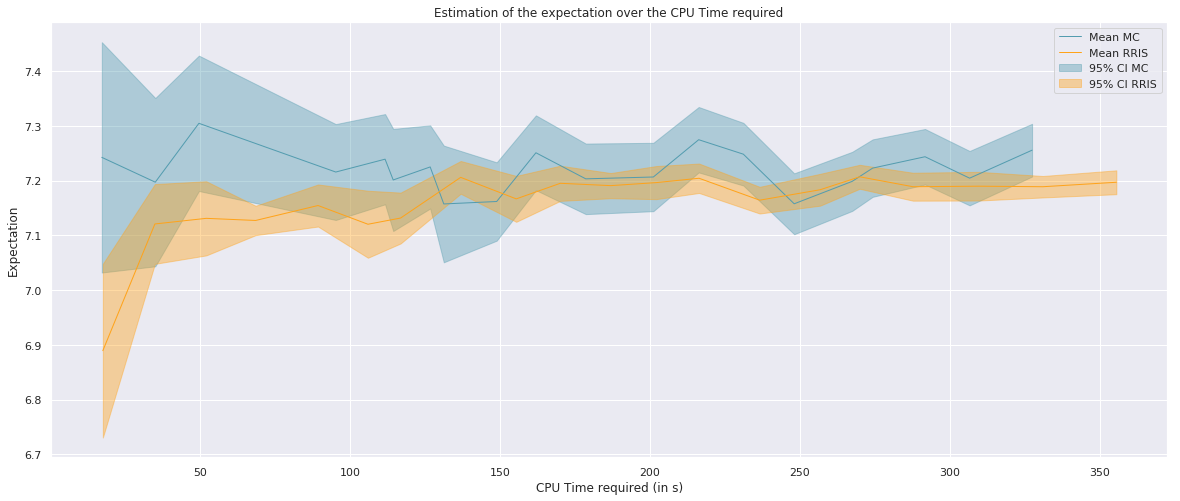

In [42]:
# Sort time_l and the others
E_MC = sortList(E_MC, time_l_MC)
low_l_MC = sortList(low_l_MC, time_l_MC)
high_l_MC = sortList(high_l_MC, time_l_MC)
time_l_MC = sortList(time_l_MC, time_l_MC)

figures(E_MC, low_l_MC, high_l_MC, time_l_MC, 
        E_RRIS, low_l_RRIS, high_l_RRIS, time_l_RRIS)

In [43]:
np.mean((high_l_MC - low_l_MC) / (high_l_RRIS - low_l_RRIS))

2.1886636395236034

In [44]:
10 / np.sqrt(3)

5.773502691896258

## 3.5 - Robbins - Monroe [Lemaire and Pages 2008]

In [21]:
def RobbbinsMonro(A, nu_0, Gn_T, fn, S_0, r, sigmas, portofolio, K, T):
    """Execute a Robbins-Monro algorithm on nu_0."""
    
    # Parameters
    n, _ = np.shape(Gn_T)
    d, _ = np.shape(sigmas)
    d_nu, _ = np.shape(nu_0)
    
    # Saving array
    nu = np.zeros((n+1, d_nu))
    nu[0, :] = nu_0.reshape((1, -1))
    nu_k = nu_0
    
    for k in range(n):
        
        # Extract G_k
        G_k = Gn_T[k, :].reshape((1, -1))
        
        # Compute H()
        theta = A.dot(nu_k).reshape((-1, 1))
        f_2 = f(G_k, d, S_0, r, sigmas, portofolio, K, T, theta=-theta) ** 2
        b = 2
        lambd = 1
        H = np.exp(-1/2 * lambd * np.linalg.norm(nu_k) ** b) * f_2[0, 0] *\
            (2 * theta - G_k.reshape((-1, 1)))
        
        # Apply Roobins Monro
        learning_rate = 1 / ((k + 10 * np.linalg.norm(nu_0) ** 2)) ** (0.875)
        nu_k = A.dot(nu_k) - learning_rate * H.reshape((-1, 1))
        print(k, np.linalg.norm(nu_n - nu_k))
#         print(np.linalg.norm(H))

        # Save the new nu_k
        nu[k + 1, :] = nu_k.reshape((1, -1))
        
    return nu

In [22]:
def LemairePagès(Gn_T, fn, A, nu_0, r, T, S_0, sigmas, portofolio, K, eps=10e-6):
    """Approximation of the expectation of f(G) through the RRIS algorithm"""
    
    # Parameters
    n, _ = np.shape(Gn_T)
    d, _ = np.shape(sigmas)
    
    # Compute the best parameter \nu
    nu = RobbbinsMonro(A, nu_0, Gn_T, fn, S_0, r, sigmas, portofolio, K, T)
    
    # Loop for computing the mean
    S = 0
    
    for k in range(n):
        
        # Extract G_k
        G_k = Gn_T[k, :].reshape((1, -1))
        
        # Extract theta_k
        theta_k = A.dot(nu[k, :].reshape((-1, 1))).reshape((-1, 1))
        
        # Compute f
        f_k = f(G_k, d, S_0, r, sigmas, portofolio, K, T, theta=theta_k)
        
        # Compute proba
        G_k = G_k.reshape((-1, 1))
        p = np.exp(1/2 * ((G_k + theta_k).T.dot(G_k + theta_k) - G_k.T.dot(G_k)))
        
        # Update sum
        S += 1/n * f_k * p
    
    return S, nu[-1, :].reshape((-1, 1))

In [23]:
## Runs the simulation
E, nu_n_LP = simulations(Gn_s, fn, n, A, nu_0, r, T, S_0, sigmas, portofolio, K,
                         simulator=LemairePagès)

0 3.101113941909304
1 3.101113941909304
2 3.101113941909304
3 3.101113941909304
4 3.101113941909304
5 3.101113941909304
6 3.101113941909304
7 3.101113941909304
8 3.100520196107921
9 3.100520196107921
10 3.100520196107921
11 3.100520196107921
12 3.100520196107921
13 3.100520196107921
14 3.1004865650994136
15 3.1004865650994136
16 3.1002254121781516
17 3.0984657613961146
18 3.0984657613961146
19 3.0984297512540713
20 3.0964230962044637
21 3.0964230962044637
22 3.0960252595161704
23 3.0960252595161704
24 3.0960252595161704
25 3.0960252595161704
26 3.0960252595161704
27 3.0960252595161704
28 3.0903765292222274
29 3.0903765292222274
30 3.0903755780176834
31 3.0903755780176834
32 3.0903102072766613
33 3.0903102072766613
34 3.0903102072766613
35 3.0888180863505257
36 3.0883912958390316
37 3.0883912958390316
38 3.0851475360331158
39 3.0851475360331158
40 3.0851475360331158
41 3.0851475360331158
42 3.0851475360331158
43 3.0851475360331158
44 3.0851475360331158
45 3.0851475360331158
46 3.0851395

433 3.024428607803106
434 3.0244231734937115
435 3.0232650624958923
436 3.0232650624958923
437 3.0232650624958923
438 3.0232650624958923
439 3.0221928770161672
440 3.0220422486825154
441 3.0220422486825154
442 3.0220422486825154
443 3.0219903169577926
444 3.0219903169577926
445 3.0219903169577926
446 3.021862496699036
447 3.021862440667113
448 3.021862440667113
449 3.021862440667113
450 3.021862440667113
451 3.021862440667113
452 3.021862440667113
453 3.021862440667113
454 3.021862440667113
455 3.020952795939082
456 3.020952795939082
457 3.020888977314181
458 3.020888977314181
459 3.020888977314181
460 3.020888977314181
461 3.020888977314181
462 3.020831333613631
463 3.020831333613631
464 3.020831333613631
465 3.020831333613631
466 3.020831333613631
467 3.020831333613631
468 3.0206217950262633
469 3.0206217950262633
470 3.0206217950262633
471 3.0206217950262633
472 3.0206217950262633
473 3.0206217950262633
474 3.0206217950262633
475 3.0206217950262633
476 3.0205588798276723
477 3.02024

834 2.9830376208275946
835 2.9830117893501447
836 2.9830117893501447
837 2.9830117893501447
838 2.982905056207663
839 2.982905056207663
840 2.9828342941791908
841 2.9828211408854157
842 2.9828211408854157
843 2.9828211408854157
844 2.9828211408854157
845 2.9828211408854157
846 2.9828211408854157
847 2.9828211408854157
848 2.9828211408854157
849 2.9828211408854157
850 2.9828211408854157
851 2.9828211408854157
852 2.9828211408854157
853 2.982767077107496
854 2.98214610336333
855 2.98214610336333
856 2.98214610336333
857 2.98214610336333
858 2.9820385325077337
859 2.9815394183125585
860 2.9815394183125585
861 2.981439108909394
862 2.980286442451188
863 2.9800076206021626
864 2.9800076206021626
865 2.9800076206021626
866 2.9800076206021626
867 2.9800076206021626
868 2.9800076206021626
869 2.9800076206021626
870 2.9800076206021626
871 2.9800076206021626
872 2.9799895201510265
873 2.9799895201510265
874 2.9799895201510265
875 2.9799895201510265
876 2.979965066829003
877 2.979965066829003
878

1211 2.9523524723349377
1212 2.9519039563878935
1213 2.9519039563878935
1214 2.9519039563878935
1215 2.9519039563878935
1216 2.9519039563878935
1217 2.9519039563878935
1218 2.9518938763607756
1219 2.9518938763607756
1220 2.9518938763607756
1221 2.9518938763607756
1222 2.9516826282501762
1223 2.9516825121589574
1224 2.9516825121589574
1225 2.9514207197655185
1226 2.9514207197655185
1227 2.9514207197655185
1228 2.950157235845922
1229 2.9496346217943894
1230 2.9496346217943894
1231 2.9496346217943894
1232 2.9496346217943894
1233 2.9492511772038146
1234 2.9492511772038146
1235 2.9492511772038146
1236 2.9492232692396145
1237 2.9492232692396145
1238 2.9492232692396145
1239 2.9490833670351213
1240 2.9490833670351213
1241 2.9490833670351213
1242 2.9490833670351213
1243 2.94905527782315
1244 2.94905527782315
1245 2.94905527782315
1246 2.94905527782315
1247 2.94905527782315
1248 2.94905527782315
1249 2.9489579077951142
1250 2.9489579077951142
1251 2.9488426643626195
1252 2.9488426643626195
1253 

1623 2.9222079072712024
1624 2.9222079072712024
1625 2.9221354436767446
1626 2.9221354436767446
1627 2.922078078713715
1628 2.921019154406791
1629 2.921019154406791
1630 2.921019154406791
1631 2.921019154406791
1632 2.921019154406791
1633 2.921019154406791
1634 2.920968056402088
1635 2.920968056402088
1636 2.920968056402088
1637 2.920968056402088
1638 2.920968056402088
1639 2.920968056402088
1640 2.920968056402088
1641 2.920968056402088
1642 2.920128009561323
1643 2.920125645790055
1644 2.9200878040642473
1645 2.9200878040642473
1646 2.9200878040642473
1647 2.9200878040642473
1648 2.9200878040642473
1649 2.9200878040642473
1650 2.9200878040642473
1651 2.9200878040642473
1652 2.919818322293936
1653 2.919818322293936
1654 2.919818322293936
1655 2.919818322293936
1656 2.919818322293936
1657 2.919818322293936
1658 2.9198022034457534
1659 2.9198021634574776
1660 2.9198021634574776
1661 2.9198021634574776
1662 2.919380744857825
1663 2.919380744857825
1664 2.919380744857825
1665 2.91915458731

1999 2.8978528773076517
2000 2.8975832725764894
2001 2.8975832725764894
2002 2.897579783220087
2003 2.897579288396033
2004 2.897479575935362
2005 2.897479575935362
2006 2.897479575935362
2007 2.897479575935362
2008 2.897479575935362
2009 2.897479575935362
2010 2.897479575935362
2011 2.8972508921776354
2012 2.8972508921776354
2013 2.8972354010258816
2014 2.8972354010258816
2015 2.8972354010258816
2016 2.8972354010258816
2017 2.8971075551431853
2018 2.8968568238733794
2019 2.8968568238733794
2020 2.896756556636174
2021 2.896756556636174
2022 2.8967067352343694
2023 2.8967067352343694
2024 2.8967067352343694
2025 2.8966699154882196
2026 2.8966586403445995
2027 2.896418625957644
2028 2.896418625957644
2029 2.896418625957644
2030 2.8964037958528785
2031 2.895742830339077
2032 2.895742830339077
2033 2.895283184852849
2034 2.895283184852849
2035 2.895283184852849
2036 2.895283184852849
2037 2.895173467942653
2038 2.894870212879045
2039 2.8948280875215286
2040 2.8948280875215286
2041 2.8948280

2398 2.8692885373383112
2399 2.8692885373383112
2400 2.8692885373383112
2401 2.8692885373383112
2402 2.8692885373383112
2403 2.8692885373383112
2404 2.8692885373383112
2405 2.8692227235845524
2406 2.8692227235845524
2407 2.8692227235845524
2408 2.8691950038860865
2409 2.8691950038860865
2410 2.8691950038860865
2411 2.8691950038860865
2412 2.8691845591526164
2413 2.8691845591526164
2414 2.8691845591526164
2415 2.8691845591526164
2416 2.8691845591526164
2417 2.8684372650040277
2418 2.8684372650040277
2419 2.868432847090018
2420 2.868432847090018
2421 2.868420629012281
2422 2.8678628320847124
2423 2.8678628320847124
2424 2.8678628320847124
2425 2.8678628320847124
2426 2.8678628320847124
2427 2.867829461416889
2428 2.867829461416889
2429 2.867829461416889
2430 2.867827993932437
2431 2.867827993932437
2432 2.867827993932437
2433 2.867827993932437
2434 2.867827993932437
2435 2.867827993932437
2436 2.867827993932437
2437 2.867827993932437
2438 2.86774832550113
2439 2.86774832550113
2440 2.867

2792 2.8377463107043757
2793 2.8377463107043757
2794 2.8377409023981706
2795 2.8377321697758346
2796 2.8377321697758346
2797 2.8377265834161047
2798 2.8377265834161047
2799 2.8377265834161047
2800 2.8377265834161047
2801 2.8377242348518874
2802 2.8377242348518874
2803 2.8377242348518874
2804 2.8377242348518874
2805 2.8377222643777236
2806 2.8375963206726214
2807 2.8375963206726214
2808 2.8375963206726214
2809 2.8375963206726214
2810 2.8375963206726214
2811 2.8375963206726214
2812 2.8375963206726214
2813 2.8375963206726214
2814 2.8375963206726214
2815 2.8375963206726214
2816 2.8375963206726214
2817 2.8375963206726214
2818 2.8375963206726214
2819 2.8375963206726214
2820 2.8375963206726214
2821 2.8374700375991018
2822 2.8374700375991018
2823 2.837399843664403
2824 2.837399843664403
2825 2.8363495583770555
2826 2.835869017673684
2827 2.835869017673684
2828 2.8358561808186806
2829 2.8358561808186806
2830 2.8358452804833454
2831 2.8358452804833454
2832 2.8358452804833454
2833 2.8358452804833

3162 2.820356420591556
3163 2.820356420591556
3164 2.820356420591556
3165 2.820356420591556
3166 2.820356420591556
3167 2.820356420591556
3168 2.820356420591556
3169 2.820356420591556
3170 2.820356420591556
3171 2.820326190379645
3172 2.820326190379645
3173 2.820107489477644
3174 2.820107489477644
3175 2.820107489477644
3176 2.819552279807889
3177 2.8191681832345608
3178 2.818666064459683
3179 2.818666064459683
3180 2.818666064459683
3181 2.818666064459683
3182 2.8183926555279513
3183 2.8183926555279513
3184 2.818314222969411
3185 2.818314222969411
3186 2.818314222969411
3187 2.8182520581640302
3188 2.8182520581640302
3189 2.8182520581640302
3190 2.8182520581640302
3191 2.8182520581640302
3192 2.8182520581640302
3193 2.8176506249004993
3194 2.8176506249004993
3195 2.8175568982250025
3196 2.817413991729054
3197 2.817413991729054
3198 2.817413991729054
3199 2.817413715127437
3200 2.8172750721144855
3201 2.8172750721144855
3202 2.8172750721144855
3203 2.817252412523648
3204 2.817252412523

3561 2.793052222925375
3562 2.793052222925375
3563 2.793050395537566
3564 2.7930492843440433
3565 2.7930492843440433
3566 2.7930492843440433
3567 2.7930492843440433
3568 2.7930492843440433
3569 2.7930492843440433
3570 2.7930492843440433
3571 2.7930492843440433
3572 2.7930071635128844
3573 2.7930071635128844
3574 2.7930071635128844
3575 2.7929493373069825
3576 2.7929493373069825
3577 2.7929493373069825
3578 2.792830528475649
3579 2.792812683923333
3580 2.792812683923333
3581 2.792812683923333
3582 2.792812683923333
3583 2.792812683923333
3584 2.792812683923333
3585 2.792812683923333
3586 2.792812683923333
3587 2.792438105374066
3588 2.7921635778391902
3589 2.7921635778391902
3590 2.792150785238399
3591 2.792150785238399
3592 2.792150785238399
3593 2.792150785238399
3594 2.792150785238399
3595 2.7921506991115748
3596 2.7921506991115748
3597 2.7921506991115748
3598 2.7921506991115748
3599 2.7919262748966123
3600 2.7919179650694907
3601 2.7919179650694907
3602 2.791840680265863
3603 2.7918

3986 2.7693527903590773
3987 2.7693527903590773
3988 2.7693527903590773
3989 2.7693527903590773
3990 2.7693527903590773
3991 2.7693111876297785
3992 2.7693111876297785
3993 2.76917254850899
3994 2.76917254850899
3995 2.76917254850899
3996 2.76917254850899
3997 2.769170921338215
3998 2.769170921338215
3999 2.769170921338215
4000 2.769156316855277
4001 2.769156316855277
4002 2.769156316855277
4003 2.769156316855277
4004 2.7691473263424773
4005 2.768912081013409
4006 2.768912081013409
4007 2.768912081013409
4008 2.768912081013409
4009 2.768908595119554
4010 2.7688626294583836
4011 2.7688626294583836
4012 2.768784071048964
4013 2.768784071048964
4014 2.768784071048964
4015 2.7683842245559447
4016 2.768294435261464
4017 2.768294435261464
4018 2.768294435261464
4019 2.768294435261464
4020 2.768294435261464
4021 2.768294435261464
4022 2.7682943396024022
4023 2.7682943396024022
4024 2.7682943396024022
4025 2.7682943396024022
4026 2.7682943396024022
4027 2.7682943396024022
4028 2.76829433960240

4341 2.748506609824066
4342 2.7482546563484087
4343 2.7482546563484087
4344 2.7480375376146084
4345 2.7480375376146084
4346 2.7480375376146084
4347 2.7480375376146084
4348 2.7480375376146084
4349 2.7480375376146084
4350 2.7480375376146084
4351 2.7480375376146084
4352 2.748037519492703
4353 2.7479931617495894
4354 2.7479931617495894
4355 2.7479931617495894
4356 2.7479931617495894
4357 2.7479931617495894
4358 2.7479931617495894
4359 2.747819728094746
4360 2.7468928076272587
4361 2.7468928076272587
4362 2.746798422240045
4363 2.746798422240045
4364 2.746798422240045
4365 2.746798422240045
4366 2.746798422240045
4367 2.7467648642812756
4368 2.7467559758876736
4369 2.7467559758876736
4370 2.746671437767676
4371 2.746671437767676
4372 2.746671437767676
4373 2.746633601767243
4374 2.746630409427588
4375 2.7463675873213083
4376 2.7463675873213083
4377 2.7463675873213083
4378 2.7463675873213083
4379 2.746248236684405
4380 2.746248236684405
4381 2.746248236684405
4382 2.746248236684405
4383 2.74

4781 2.7169461208671235
4782 2.7169461208671235
4783 2.716946113376159
4784 2.716946113376159
4785 2.716946113376159
4786 2.716946113376159
4787 2.716946113376159
4788 2.716946113376159
4789 2.716946113376159
4790 2.716946113376159
4791 2.7162893023234296
4792 2.7162893023234296
4793 2.7162893023234296
4794 2.7162893023234296
4795 2.7162893023234296
4796 2.7162844002831252
4797 2.7162844002831252
4798 2.716230284185055
4799 2.7160708166410985
4800 2.7159717260147236
4801 2.7159702076665138
4802 2.7159702076665138
4803 2.7159702076665138
4804 2.7159702076665138
4805 2.7159702076665138
4806 2.7159702076665138
4807 2.7159702076665138
4808 2.715967144703521
4809 2.715967144703521
4810 2.715967144703521
4811 2.71583984971136
4812 2.71583984971136
4813 2.7157275309459363
4814 2.7157275309459363
4815 2.7157275309459363
4816 2.715460043970604
4817 2.715460043970604
4818 2.7149483977404856
4819 2.7149483977404856
4820 2.7149483977404856
4821 2.7149483977404856
4822 2.7149483977404856
4823 2.714

5148 2.6920007932396994
5149 2.691951350588617
5150 2.691950114460005
5151 2.691950114460005
5152 2.691868917496464
5153 2.691868917496464
5154 2.6912731781986508
5155 2.690004931194766
5156 2.6895464695769613
5157 2.6895464695769613
5158 2.6895464695769613
5159 2.6895464695769613
5160 2.6895464695769613
5161 2.6895464695769613
5162 2.6895464695769613
5163 2.6895464695769613
5164 2.6895464695769613
5165 2.6895464695769613
5166 2.689124240537062
5167 2.689114883699272
5168 2.689114883699272
5169 2.6891032321761323
5170 2.6891032321761323
5171 2.688443574304403
5172 2.6882268170020382
5173 2.6880846909143283
5174 2.6880846909143283
5175 2.6880846909143283
5176 2.6880663809713035
5177 2.6880663809713035
5178 2.6880663809713035
5179 2.6880663809713035
5180 2.6880663809713035
5181 2.6880663809713035
5182 2.688032861079188
5183 2.688032861079188
5184 2.688032861079188
5185 2.688032861079188
5186 2.688032861079188
5187 2.688027697600106
5188 2.688027697600106
5189 2.688027697600106
5190 2.688

5560 2.662037929616015
5561 2.6620345635601743
5562 2.66203359238194
5563 2.66203359238194
5564 2.66203359238194
5565 2.66203359238194
5566 2.66203359238194
5567 2.66203359238194
5568 2.66203359238194
5569 2.6610378564192994
5570 2.6610378564192994
5571 2.6610378564192994
5572 2.6610378564192994
5573 2.6610378564192994
5574 2.660532835411431
5575 2.660532835411431
5576 2.660532835411431
5577 2.660532835411431
5578 2.660532835411431
5579 2.660532835411431
5580 2.6605051956494643
5581 2.6605051954129384
5582 2.6605051954129384
5583 2.6605051954129384
5584 2.6604801323373843
5585 2.6604801323373843
5586 2.6604801323373843
5587 2.6604801323373843
5588 2.6604801323373843
5589 2.6604801323373843
5590 2.6603193595818437
5591 2.6603193595818437
5592 2.6603049767432987
5593 2.6603049767432987
5594 2.6603045295658307
5595 2.6603045295658307
5596 2.6602798656680693
5597 2.6602798656680693
5598 2.6602798656680693
5599 2.6599033358302386
5600 2.6599033358302386
5601 2.6599033358302386
5602 2.659884

5986 2.628249439280599
5987 2.628249439280599
5988 2.628249439280599
5989 2.628249439280599
5990 2.628249439280599
5991 2.6282490230519797
5992 2.6282490230519797
5993 2.628239551317025
5994 2.628239551317025
5995 2.628221239149243
5996 2.628221239149243
5997 2.628198191048619
5998 2.628198191048619
5999 2.628198191048619
6000 2.628197586225364
6001 2.6281074857468902
6002 2.6281074857468902
6003 2.6281074857468902
6004 2.627911942282733
6005 2.6277074283567106
6006 2.6277074283567106
6007 2.6277074283567106
6008 2.6277074283567106
6009 2.6277074283567106
6010 2.6277074283567106
6011 2.6277074283567106
6012 2.627652688514699
6013 2.627548428905106
6014 2.627548428905106
6015 2.627548428905106
6016 2.627548428905106
6017 2.62754244965771
6018 2.62754244965771
6019 2.6272019353630784
6020 2.62718036061351
6021 2.62718036061351
6022 2.62718036061351
6023 2.627061416145983
6024 2.627061416145983
6025 2.627061416145983
6026 2.627061416145983
6027 2.6269609134197913
6028 2.6269609134197913
6

6382 2.5996754712598285
6383 2.5996754712598285
6384 2.598895672542458
6385 2.598895672542458
6386 2.5988581402664344
6387 2.5988581402664344
6388 2.5986572064797837
6389 2.5986572064797837
6390 2.5986572064797837
6391 2.598329656644231
6392 2.598329656644231
6393 2.598329656644231
6394 2.5983254745791893
6395 2.5983254745791893
6396 2.598321501073713
6397 2.598321501073713
6398 2.596916145759697
6399 2.596916145759697
6400 2.5967699219460254
6401 2.5967699219460254
6402 2.5967699219460254
6403 2.5967699219460254
6404 2.5967176499575193
6405 2.5966408905973504
6406 2.5966408905973504
6407 2.5966408905973504
6408 2.5966408905973504
6409 2.5966408905973504
6410 2.5966408905973504
6411 2.5966408905973504
6412 2.5966408905973504
6413 2.5966386663396457
6414 2.5966386663396457
6415 2.5966386663396457
6416 2.59662425573886
6417 2.596609460358927
6418 2.596609460358927
6419 2.596609460358927
6420 2.596609460358927
6421 2.596609460358927
6422 2.596609460358927
6423 2.5965315892626624
6424 2.59

6787 2.5625244472433026
6788 2.5625244472433026
6789 2.561852700388274
6790 2.561852700388274
6791 2.561808115333266
6792 2.561808115333266
6793 2.5618070574477607
6794 2.5618070574477607
6795 2.561626312324763
6796 2.561626312324763
6797 2.561626312324763
6798 2.5615762723593765
6799 2.5615762723593765
6800 2.561156438290279
6801 2.561156438290279
6802 2.5608692374225304
6803 2.5608692374225304
6804 2.560079278344015
6805 2.560079278344015
6806 2.560077953410045
6807 2.5596985784136237
6808 2.5596985784136237
6809 2.5596126321506936
6810 2.5595740465207553
6811 2.5595488255103693
6812 2.5595488255103693
6813 2.5595488255103693
6814 2.5595488255103693
6815 2.5595488255103693
6816 2.5595488255103693
6817 2.559340926838641
6818 2.5585637705292132
6819 2.5585637705292132
6820 2.557947396750022
6821 2.5578807726231707
6822 2.557850855078064
6823 2.557850855078064
6824 2.5577859892398185
6825 2.5577859892398185
6826 2.557778543987489
6827 2.557671891484964
6828 2.557671891484964
6829 2.5576

7192 2.522363980438413
7193 2.52232480730916
7194 2.52232480730916
7195 2.520796922374599
7196 2.517855474604494
7197 2.517855474604494
7198 2.51777840681972
7199 2.5176231085012746
7200 2.5176231085012746
7201 2.5176231085012746
7202 2.5176231085012746
7203 2.5176231085012746
7204 2.517433632095039
7205 2.517299340355587
7206 2.51725026898405
7207 2.51725026898405
7208 2.51725026898405
7209 2.5169195004432376
7210 2.5169195004432376
7211 2.5169195004432376
7212 2.5168539948476623
7213 2.516300799385384
7214 2.516108263408074
7215 2.514839804141627
7216 2.514839804141627
7217 2.51475862948583
7218 2.5145181749119128
7219 2.514510391555612
7220 2.514510391555612
7221 2.514510391555612
7222 2.5145100594691643
7223 2.514508116468409
7224 2.514508116468409
7225 2.514508116468409
7226 2.5142758425197225
7227 2.514225755758969
7228 2.5138813212053317
7229 2.5138813212053317
7230 2.513643145204719
7231 2.513643145204719
7232 2.513643145204719
7233 2.513643145204719
7234 2.5134460678312793
723

7612 2.467735453590997
7613 2.4677333874303113
7614 2.4677333874303113
7615 2.4677333874303113
7616 2.4673328714020486
7617 2.4670103450151055
7618 2.4669531968848877
7619 2.4669531040753943
7620 2.4669531040753943
7621 2.4664116892432824
7622 2.4664116892432824
7623 2.4664075705573922
7624 2.4664075705573922
7625 2.4664075705573922
7626 2.4664075705573922
7627 2.4664075705573922
7628 2.4664075705573922
7629 2.466407570555024
7630 2.466407570555024
7631 2.466407570555024
7632 2.466407570555024
7633 2.466323534386495
7634 2.466323534386495
7635 2.466071199473021
7636 2.466071199473021
7637 2.466071199473021
7638 2.466071199473021
7639 2.466071199473021
7640 2.465971777625174
7641 2.465971777625174
7642 2.465971777625174
7643 2.4659433403003392
7644 2.4659433403003392
7645 2.4659433403003392
7646 2.4659433403003392
7647 2.4659433403003392
7648 2.4659308323006286
7649 2.4659308323006286
7650 2.4659308323006286
7651 2.4659308323006286
7652 2.4659308323006286
7653 2.4658280368054406
7654 2.

8041 2.4297272990251986
8042 2.4297272990251986
8043 2.4297006568714736
8044 2.4297006568714736
8045 2.4297006568714736
8046 2.4293730118266703
8047 2.4293730118266703
8048 2.429372181181826
8049 2.4290982014775837
8050 2.4290982014775837
8051 2.4290388516585386
8052 2.4289789418212853
8053 2.4289789418212853
8054 2.4289021045984494
8055 2.4289021045984494
8056 2.4281850845781
8057 2.4281850845781
8058 2.4280627392974012
8059 2.4280627392974012
8060 2.427656890340683
8061 2.4268932655964757
8062 2.426621601702628
8063 2.426621601702628
8064 2.426621601702628
8065 2.426530910911558
8066 2.426530910911558
8067 2.4263781021327806
8068 2.4263781021327806
8069 2.4263781021327806
8070 2.4262594945762244
8071 2.4262594945762244
8072 2.4255701223159165
8073 2.4252390151074303
8074 2.4244274544612177
8075 2.4244274544612177
8076 2.4244274544612177
8077 2.4244274544612177
8078 2.4244274544612177
8079 2.4243542349770006
8080 2.424330540809299
8081 2.424330540809299
8082 2.4243198454856243
8083 2.

8453 2.3675854047457467
8454 2.3675854047457467
8455 2.3675854047457467
8456 2.3674416475240547
8457 2.3674416475240547
8458 2.3674416475240547
8459 2.367290217183086
8460 2.367057507711695
8461 2.3669785408443946
8462 2.3665259777190415
8463 2.366458594174459
8464 2.366458594174459
8465 2.3661854545490586
8466 2.3654908001172945
8467 2.3654908001091495
8468 2.3654908001091495
8469 2.3654908001091495
8470 2.365483046552877
8471 2.365483046552877
8472 2.3654823263161604
8473 2.364970609181978
8474 2.3649236441903447
8475 2.363764384118137
8476 2.363764069152106
8477 2.363764069152106
8478 2.363569000357928
8479 2.3634743568797982
8480 2.362827810528885
8481 2.362827810528885
8482 2.362827810528885
8483 2.3626210495865094
8484 2.3621290814141753
8485 2.362028890386654
8486 2.362028890386654
8487 2.362028890386654
8488 2.362028890386654
8489 2.3611985765843535
8490 2.3611985765843535
8491 2.3610852434864613
8492 2.3610852434864613
8493 2.3610852434864613
8494 2.3604825894429773
8495 2.360

8803 2.3126135269437844
8804 2.312587465099741
8805 2.312587465099741
8806 2.312200586022226
8807 2.311213786236546
8808 2.3111779152401346
8809 2.311148041212
8810 2.311148041212
8811 2.3099570962252125
8812 2.3099570962252125
8813 2.3099570962252125
8814 2.309768245432903
8815 2.309718599938394
8816 2.309692084571134
8817 2.309425916527171
8818 2.3092863347313393
8819 2.3078383912913734
8820 2.3078383912913734
8821 2.307827283732923
8822 2.307827283732923
8823 2.307827283732923
8824 2.3078051669703474
8825 2.3070236693228368
8826 2.307021467439847
8827 2.3068103065544774
8828 2.3068103065544774
8829 2.306755396751149
8830 2.306755396751149
8831 2.306755396751149
8832 2.306755396751149
8833 2.306755396751149
8834 2.3066768353012597
8835 2.3065390426015626
8836 2.3065390426015626
8837 2.3065390426015626
8838 2.3065390426015626
8839 2.3063872207794347
8840 2.3063872207794347
8841 2.3063872207794347
8842 2.30629682891922
8843 2.30629682891922
8844 2.3057674633016507
8845 2.30576746330165

9212 2.243473195602246
9213 2.24345137606057
9214 2.243115722788504
9215 2.243115722788504
9216 2.243115722788504
9217 2.2431022383067147
9218 2.2431022383067147
9219 2.24199256178146
9220 2.24199256178146
9221 2.24199256178146
9222 2.2419851932605814
9223 2.2419851932605814
9224 2.241977068068947
9225 2.241956111349833
9226 2.241956111349833
9227 2.241956111349833
9228 2.241956111349833
9229 2.2409532575403572
9230 2.240537424895732
9231 2.2398199254131277
9232 2.2382477487164474
9233 2.2382477487164474
9234 2.2377641809657374
9235 2.2377641809657374
9236 2.2375615107935825
9237 2.2375583531425853
9238 2.2373853407335536
9239 2.2373771288744937
9240 2.2373771288744937
9241 2.2373771288744937
9242 2.236498609096727
9243 2.2364221500256747
9244 2.2359241948491984
9245 2.2359241948491984
9246 2.2359241948491984
9247 2.2359241948491984
9248 2.2359241948491984
9249 2.2359241948491984
9250 2.232026468277674
9251 2.2320113691853516
9252 2.2320113691853516
9253 2.230169625152361
9254 2.229331

9619 2.168387719989965
9620 2.1679042939979407
9621 2.1676414321592934
9622 2.1674632927967115
9623 2.166708518153714
9624 2.164824562320481
9625 2.164800085877478
9626 2.164800085877478
9627 2.164800085877478
9628 2.164800085877478
9629 2.164795657520861
9630 2.161998221769236
9631 2.161998221769236
9632 2.1619973169078524
9633 2.1613627083653366
9634 2.1613627083653366
9635 2.161304733235506
9636 2.161304733235506
9637 2.161304733235506
9638 2.16023672590243
9639 2.16023672590243
9640 2.1598587719239237
9641 2.159828846443579
9642 2.158946759223295
9643 2.157062114304399
9644 2.157062114304399
9645 2.1563092374932213
9646 2.1562105971107326
9647 2.1562105971107326
9648 2.156082743050348
9649 2.156082743050348
9650 2.156082743050348
9651 2.1560761356329037
9652 2.1560761356329037
9653 2.154170044936259
9654 2.154170044936259
9655 2.154170044936259
9656 2.152099273904726
9657 2.152099273904726
9658 2.152099273904726
9659 2.1511650667226854
9660 2.1511650667226854
9661 2.151165066722685

In [230]:
print(E)

[[296383.83388465]]


In [70]:
print(np.linalg.norm(nu_0))

3.506196780732217
